<a href="https://colab.research.google.com/github/ma850419/FlexibleNet/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from osgeo import gdal
#filepath = r'/content/PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif'
#filepath = r'/content/Sub_Sentinel2_.tif'
filepath = r'/content/drive/MyDrive/Hyperion_0_2007-03-07.tif'
# https://stackoverflow.com/questions/43684072/how-to-import-multiple-bands-from-an-image-into-numpy
# Load one GeoTIFF image using GDAL
dataset = gdal.Open(filepath)
#nodata_value = dataset.GetRasterBand(1).GetNoDataValue()
projInfo = dataset.GetProjection()
trans = dataset.GetGeoTransform()
print(projInfo,dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount )
#print(me)
#image = np.zeros(( dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount))
image = dataset.ReadAsArray()
image3 = np.transpose(image,(1,2,0))
  # <class 'numpy.ndarray'>
#print(image2.shape) 
#print(image.dtype)  
#print(image.dtype)

In [ ]:
print(image3.max())
image3=image3/image3.max()
print(image3.max())

In [1]:
!pip install richdem
!pip install pyhdf
!pip install pysptools
!pip install spectral
!pip install surehyp
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp39-cp39-linux_x86_64.whl size=7970725 sha256=5bdac348d6e9a8cc503510a6b7d84a0e61628ba9b99c5e06672a379fa7c66bc2
  Stored in directory: /root/.cache/pip/wheels/c3/e1/43/02e9a8e971c959066d5725ecb303dc327c6a9fc8a1b9d714c1
Successfully built richdem
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.8/739.8 kB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=813

In [2]:
import numpy as np
import rasterio
import sys
import ee
from functools import partial
from multiprocessing import Pool
import sys, os
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

import surehyp.preprocess
import surehyp.atmoCorrection
import ee
#ee.Authenticate()

# Initialize the library.
#ee.Initialize()

def preprocess_radiance(fname,pathToL1Rmetadata,pathToL1Rimages,pathToL1Timages,pathToL1TimagesFiltered,pathOut,nameOut,destripingMethod='Pal',localDestriping=False,smileCorrectionOrder=2,checkSmile=False):
    print('concatenate the L1T image')
    surehyp.preprocess.processImage(fname,pathToL1Timages,pathToL1TimagesFiltered)

    print('read the L1R image')
    arrayL1R=surehyp.preprocess.readL1R(pathToL1Rimages+fname+'/',fname)

    print('get the L1R image parameters')
    metadata,bands,fwhms=surehyp.preprocess.getImageMetadata(pathToL1Rimages+fname+'/',fname)

    print('separates VNIR and SWIR')
    VNIR,VNIRb,VNIRfwhm,SWIR,SWIRb,SWIRfwhm=surehyp.preprocess.separating(arrayL1R,bands,fwhms)

    print('converts DN to radiance')
    VNIR,SWIR=surehyp.preprocess.DN2Radiance(VNIR,SWIR)

    print('aligning VNIR and SWIR, part 1')
    VNIR,SWIR=surehyp.preprocess.alignSWIR2VNIRpart1(VNIR,SWIR)

    print('desmiling')
    VNIR=surehyp.preprocess.smileCorrectionAll(VNIR,smileCorrectionOrder,check=checkSmile)
    SWIR=surehyp.preprocess.smileCorrectionAll(SWIR,smileCorrectionOrder,check=checkSmile)

    if destripingMethod=='Datt':
        print('destriping - Datt (2003)')
        VNIR=surehyp.preprocess.destriping(VNIR,'VNIR',0.11)
        SWIR=surehyp.preprocess.destriping(SWIR,'SWIR',0.11)
    elif destripingMethod=='Pal':
        print('destriping -  Pal et al. (2020)')
        VNIR,nc=surehyp.preprocess.destriping_quadratic(VNIR)
        if localDestriping==True:
            VNIR=surehyp.preprocess.destriping_local(VNIR,nc)
        SWIR,nc=surehyp.preprocess.destriping_quadratic(SWIR)
        if localDestriping==True:
            SWIR=surehyp.preprocess.destriping_local(SWIR,nc)
    else:
        print('no destriping method selected -> no destriping')

    #print('aligning VNIR and SWIR, part 2')
    #VNIR,SWIR=surehyp.preprocess.alignSWIR2VNIRpart2(VNIR,VNIRb,SWIR,SWIRb)

    print('assemble VNIR and SWIR')
    arrayL1R,wavelengths,fwhms=surehyp.preprocess.concatenateImages(VNIR,VNIRb,VNIRfwhm,SWIR,SWIRb,SWIRfwhm)

    print('smooth the cirrus bands for later thin cirrus removal') #may be necessary for Hyperion as an incomplete destriping for this band would then affect every other band during the thin cirrus removal
    arrayL1R=surehyp.preprocess.smoothCirrusBand(arrayL1R,wavelengths)

    print('georeference the corrected L1R data using the L1T data')
    arrayL1Rgeoreferenced, metadataGeoreferenced=surehyp.preprocess.georeferencing(arrayL1R,pathToL1TimagesFiltered,fname)

    print('save the processed image as an ENVI file')
    surehyp.preprocess.savePreprocessedL1R(arrayL1Rgeoreferenced,wavelengths,fwhms,metadataGeoreferenced,pathToL1Rimages,pathToL1Rmetadata,metadata,fname,pathOut+nameOut)

    for f in os.listdir(pathOut):
        if (fname in f) and ('_tmp' in f):
            os.remove(os.path.join(pathOut,f))

    return pathOut+nameOut

def atmosphericCorrection(pathToRadianceImage,pathToOutImage,stepAltit=1,stepTilt=15,stepWazim=30,demID='NRCan/CDEM',elevationName='elevation',topo=False,smartsAlbedoFilePath='./SMARTS2981-PC_Package/Albedo/Albedo.txt'):
    print('open processed radiance image')
    L,bands,fwhms,processing_metadata,metadata=surehyp.atmoCorrection.getImageAndParameters(pathToRadianceImage)

    ####
    #get info from the processing metadata for clearer visualization in the input of the subsequent functions
    longit=processing_metadata['longit']
    latit=processing_metadata['latit']
    datestamp1=processing_metadata['datestamp1']
    zenith=processing_metadata['zenith']
    azimuth=processing_metadata['azimuth']
    satelliteZenith=np.abs(processing_metadata['satelliteZenith'])
    satelliteAzimuth=processing_metadata['satelliteAzimuth']

    UL_lat=processing_metadata['UL_lat']
    UL_lon=processing_metadata['UL_lon']
    UR_lat=processing_metadata['UR_lat']
    UR_lon=processing_metadata['UR_lon']
    LL_lat=processing_metadata['LL_lat']
    LL_lon=processing_metadata['LL_lon']
    LR_lat=processing_metadata['LR_lat']
    LR_lon=processing_metadata['LR_lon']

    year=processing_metadata['year']
    doy=processing_metadata['doy']
    ####

    if topo==True:
        print('download DEM images from GEE')
        path_to_dem = surehyp.atmoCorrection.getDEMimages(UL_lon,UL_lat,UR_lon,UR_lat,LR_lon,LR_lat,LL_lon,LL_lat,demID=demID,elevationName=elevationName)

        print('reproject DEM images')
        path_to_reprojected_dem = surehyp.atmoCorrection.reprojectDEM(pathToRadianceImage,path_elev=path_to_dem)

        print('resampling')
        path_elev=surehyp.atmoCorrection.matchResolution(pathToRadianceImage,path_elev=path_to_reprojected_dem)

        print("extract the data corresponding to the Hyperion image's pixels")
        elev, slope, wazim=surehyp.atmoCorrection.extractDEMdata(pathToRadianceImage,path_elev=path_elev)
    else:
        slope=None
        wazim=None

    print('get clouds and shadows mask')
    clearview, clouds, shadows = surehyp.atmoCorrection.cloudAndShadowsDetection(bands,L,latit,doy,satelliteZenith,zenith,azimuth,slope,wazim)

    np.save(pathToOutImage+'_cloud_mask',clouds)
    np.save(pathToOutImage+'_shadows_mask',shadows)
    np.save(pathToOutImage+'_clearview_mask',clearview)

    print('get haze spectrum')
    L,Lhaze=surehyp.atmoCorrection.darkObjectDehazing(L,bands)

    print('mask non clearview pixels')
    L[clearview==0]=0

    print('removal of thin cirrus')
    L=surehyp.atmoCorrection.cirrusRemoval(bands,L,latit,doy,satelliteZenith,zenith,azimuth)



    print('get average elevation of the scene from GEE')
    altit=surehyp.atmoCorrection.getGEEdem(UL_lat,UL_lon,UR_lat,UR_lon,LL_lat,LL_lon,LR_lat,LR_lon,demID=demID,elevationName=elevationName)

    print('get atmosphere content')
    wv,o3,flag_no_o3=surehyp.atmoCorrection.getAtmosphericParameters(bands,L,datestamp1,year,doy,longit,latit,altit,satelliteZenith,zenith,azimuth)

    if flag_no_o3==True:
        IO3=1
    else:
        IO3=0

    ########################################
    # Atmospheric correction -- flat surface
    print('obtain radiative transfer outputs')
    #get the atmosphere parameters for the sun-ground section using the image acquisition time to determine sun angle
    df=surehyp.atmoCorrection.runSMARTS(ALTIT=altit,LATIT=latit,IMASS=0,ZENITH=zenith,AZIM=azimuth,SUNCOR=surehyp.atmoCorrection.get_SUNCOR(doy),IH2O=0,WV=wv,IO3=IO3,IALT=0,AbO3=o3)
    #get the atmosphere parameters for the ground-satellite section by setting the 'sun' (in SMARTS) at the satellite zenith position to get the transmittance over the correct optical path length
    df_gs=surehyp.atmoCorrection.runSMARTS(ALTIT=altit,LATIT=0,LONGIT=0,IMASS=0,SUNCOR=surehyp.atmoCorrection.get_SUNCOR(doy),ITURB=5,ZENITH=satelliteZenith,AZIM=0,IH2O=0,WV=wv,IO3=IO3,IALT=0,AbO3=o3)

    print('compute radiance to reflectance')
    R=surehyp.atmoCorrection.computeLtoR(L,bands,df,df_gs)

    if topo==False:
        print('save the reflectance image')
        surehyp.atmoCorrection.saveRimage(R,metadata,pathToOutImage)
    else:
        #######################################
        #atmospheric correction -- rough terrain
        print('write Albedo.txt file for SMARTS')
        pathToAlbedoFile=surehyp.atmoCorrection.writeAlbedoFile(R,bands,pathOut=smartsAlbedoFilePath)

        print('get scene background reflectance')
        sp=pd.read_csv(pathToAlbedoFile,header=3,sep='\s+')
        w=sp.values[:,0]
        r=sp.values[:,1]
        f=interpolate.interp1d(w,r,bounds_error=False,fill_value='extrapolate')
        rho_background=f(df['Wvlgth']*1E-3)

        print('computing the LUT for the rough terrain correction')
        R=surehyp.atmoCorrection.getDemReflectance(altitMap=elev,tiltMap=slope,wazimMap=wazim,stepAltit=stepAltit,stepTilt=stepTilt,stepWazim=stepWazim,latit=latit,IH2O=0,WV=wv,IO3=IO3,IALT=0,AbO3=o3,doy=doy,zenith=zenith,azimuth=azimuth,satelliteZenith=satelliteZenith,satelliteAzimuth=satelliteAzimuth,L=L,bands=bands,IALBDX=1,rho_background=rho_background)

        print('MM topography correction')
        R=surehyp.atmoCorrection.MM_topo_correction(R,bands,slope*np.pi/180,wazim*np.pi/180,zenith*np.pi/180,azimuth*np.pi/180)

        print('save the reflectance image')
        surehyp.atmoCorrection.saveRimage(R,metadata,pathToOutImage)

    return pathToOutImage




In [ ]:
if __name__ == '__main__':
#ee.Initialize()

    # if using SMARTS 295, point to the *bat.exe
    #os.environ['SMARTSPATH']='./SMARTS_295_PC/' #Path to the SMARTS folder
    #surehyp.atmoCorrection.smartsVersion='smarts295'
    #surehyp.atmoCorrection.smartsExecutable='smarts295bat.exe'
    # else point to the regular exe
    #os.environ['SMARTSPATH']='./SMARTS2981-PC_Package/' #Path to the SMARTS folder
    #surehyp.atmoCorrection.smartsVersion='smarts298'
    #surehyp.atmoCorrection.smartsExecutable='smarts2981_PC_64bit.exe'
    pathToL1Rmetadata='./content/L1R/EO1H1740362009289110K4/EO1H1740362009289110K4.MET' #path to the Hyperion metadata file provided by the USGS
    pathToL1Rimages="/content/L1R/" #contains the uncompressed L1R folders ( that contain the .AUX,.jdr,.L1R,.MET, .fgdc files)
    pathToL1Timages="/content/L1T/" #contains the zip files of the L1T images (that contain a TIF file for each band)
    pathToL1TimagesFiltered="/content/L1T/filteredImages/" #contains the TIF L1R images, each TIF file containing all bands

    pathOut='/content/OUT/' # folder where the outputs of SUREHYP will be written
    fname='EO1H1740362009289110K4' # ID of the Hyperion image
    nameOut=fname+'_test' # name of the corrected radiance image that will be save by preprocess_radiance, and will be opened by atmosphericCorrection
    #pathToRadianceImage=preprocess_radiance(fname,pathToL1Rmetadata,pathToL1Rimages,pathToL1Timages,pathToL1TimagesFiltered,pathOut,fname+'_test',destripingMethod='Pal',localDestriping=False,checkSmile=False)

    pathToRadianceImage='/content/OUT/'+nameOut
    preprocess_radiance(fname,pathToL1Rmetadata,pathToL1Rimages,pathToL1Timages,pathToL1TimagesFiltered,pathOut,nameOut,destripingMethod='Pal',localDestriping=False,smileCorrectionOrder=2,checkSmile=False)
    atmosphericCorrection(pathToRadianceImage,pathOut+fname+'_reflectance_test_flat',stepAltit=1,stepTilt=15,stepWazim=15,demID='NRCan/CDEM',elevationName='elevation',smartsAlbedoFilePath= '/content/OUT/'+'Albedo/Albedo.txt',topo=True)#smartsAlbedoFilePath=os.environ['SMARTSPATH']+'Albedo/Albedo.txt',topo=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = []
while(1):
    a.append('1')

In [ ]:
#!ls /content/drive/MyDrive/EO1*
#!unzip /content/drive/MyDrive/EO1H1740362009289110K4_1R.ZIP -d /content/L1R
!cp /content/drive/MyDrive/EO1H1740362009289110K4_1T.ZIP /content/L1T

In [ ]:
from __future__ import print_function

import os
import os.path as osp
import pysptools.classification as cls
import matplotlib.pyplot as plt
import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp
import numpy as np

n_emembers = 8


def parse_ENVI_header(head):
    ax = {}
    ax['wavelength'] = head['wavelength']
    ax['x'] = 'Wavelength - '+head['z plot titles'][0]
    ax['y'] = head['z plot titles'][1]
    return ax


class Classify(object):
    """
    For this problem NormXCorr works as well as SAM
    SID was not tested.
    """

    def __init__(self, data, E, path, threshold, suffix):
        print('Classify using SAM')
        self.sam = cls.SAM()
        self.sam.classify(data, E, threshold=threshold)
        self.path = path
        self.suffix = suffix

    def get_single_map(self, idx):
        return self.sam.get_single_map(idx, constrained=False)

    def plot_single_map(self, idx):
        self.sam.plot_single_map(self.path, idx, constrained=False, suffix=self.suffix)

    def plot(self):
        self.sam.plot(self.path, suffix=self.suffix)


def get_endmembers(data, header, q, path, mask, suffix, output=False):
    print('Endmembers extraction with NFINDR')
    ee = eea.NFINDR()
    U = ee.extract(data, q, maxit=5, normalize=True, ATGP_init=True, mask=mask)
    if output == True:
        ee.plot(path, axes=header, suffix=suffix)
    return U


def get_abundance_maps(data, U, umix_source, path, output=False):
    print('Abundance maps with FCLS')
    fcls = amp.FCLS()
    amap = fcls.map(data, U, normalize=True)
    if output == True:
        fcls.plot(path, colorMap='jet', suffix=umix_source)
    return amap


def get_full_cube_em_set(data, header, path):
    """ Return a endmembers set for the full cube and a region of interest (ROI).
        The ROI is created using a small region of the
        effluents leaving near the smokestack.
    """
    # Take the endmembers set for all the cube
    U = get_endmembers(data, header, n_emembers, path, None, 'full_cube', output=True)
    # A threshold of 0.15 give a good ROI
    cls = Classify(data, U, path, 0.15, 'full_cube')
    # The endmember EM2 is use to define the region of interest
    # i.e. the effluents region of interest
    effluents = cls.get_single_map(2)
    # Create the binary mask with the effluents
    mask = (effluents > 0)
    # Plot the mask
    plot(mask, 'gray', 'binary_mask', path)
    return U, mask


def get_masked_em_set(data, header, path, mask):
    """ Return a endmembers set that belong to the ROI (mask).
    """
    # Use the mask to extract endmembers near the smokestack exit
    U = get_endmembers(data, header, n_emembers, path, mask, 'masked', output=True)
    return U


def classification_analysis(data, path, E_masked):
    # Note: the classification is done with NormXCorr instead of SAM
    # Classify with the masked endmembers set
    c = cls.NormXCorr()
    c.classify(data, E_masked, threshold=0.15)
    c.plot_single_map(path, 'all', constrained=False, suffix='masked')
    c.plot(path, suffix='masked')
    # Calculate the average image
    gas = c.get_single_map(1, constrained=False)
    for i in range(n_emembers - 1):
        gas = gas + c.get_single_map(i+2, constrained=False)
    gas = gas / n_emembers
    # and plot it
    plot(gas, 'Spectral', 'mean_NormXCorr', path)


def unmixing_analysis(data, path, E_full_cube, E_masked):
    # Calculate an unmixed average image at the ROI position.
    # Each endmember belonging to E_masked takes place inside E_full_cube at
    # the ROI position. Netx, we sum the abundance maps
    # generated at this position. And finally a mean is calculated.
    for i in range(n_emembers):
        E_full_cube[1,:] = E_masked[i,:]
        amaps = get_abundance_maps(data, E_full_cube, 'masqued_{0}'.format(i+1), path, output=False)
        if i == 0:
            mask = amaps[:,:,1]
        else:
            mask = mask + amaps[:,:,1]
        plot(amaps[:,:,1], 'Spectral', 'FCLS_masqued_{0}'.format(i+1), path)
    mask = mask / n_emembers
    thresholded = (mask > 0.15) * mask
    plot(thresholded, 'Spectral', 'mean_FCLS', path)


def plot(image, colormap, desc, path):
    plt.ioff()
    img = plt.imshow(image, interpolation='none')
    img.set_cmap(colormap)
    plt.colorbar()
    fout = osp.join(path, '{0}.png'.format(desc))
    plt.savefig(fout)
    plt.clf()

In [ ]:
#
#------------------------------------------------------------------------------
# Copyright (c) 2013-2014, Christian Therien
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#------------------------------------------------------------------------------
#
# envi.py - This file is part of the PySptools package.
#

"""
load_ENVI_file, load_ENVI_spec_lib functions
"""


import numpy as np
import spectral.io.envi as envi

def load_ENVI_file(file_name):
    """
    Load the data and the header from an ENVI file.
    It use the SPy (spectral) library. At 'file_name' give the envi header file name.
    Parameters:
        file_name: `path string`
            The complete path to the file to load. Use the header file name.
    Returns: `tuple`
        data: `numpy array`
            A (m x n x p) HSI cube.
        head: `dictionary`
            Starting at version 0.13.1, the ENVI file header
     """
    img = envi.open(file_name)
    head = envi.read_envi_header(file_name)
    return np.array(img.load()), head


def load_ENVI_spec_lib(file_name):
    """
    Load a ENVI .sli file.
    Parameters:
        file_name: `path string`
            The complete path to the library file to load.
    Returns: `numpy array`
        A (n x p) HSI cube.
        head: `dictionary`
            Starting at version 0.13.1, the ENVI file header
    """
    sli = envi.open(file_name)
    head = envi.read_envi_header(file_name)
    return sli.spectra, head

In [ ]:
#croppping black borders outside image
def crop_image(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim >=3:
        mask = mask.all(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    #print(np.ix_(mask1,mask0))
    #print(me)
    return img[np.ix_(mask1,mask0)]

def crop_image_only_outside(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim>=3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]

In [ ]:
!unzip /content/drive/MyDrive/testhyperion.zip -d /content
#!cp /content/drive/MyDrive/testhyperion1.hdr /content/testhyperion.hdr

In [ ]:
if __name__ == '__main__':
    # Load the cube
    data_path = '/content/'
    home = '/content/'
    result_path = os.path.join(home, 'results')
    sample = 'testhyperion.hdr'
    data_file = osp.join(data_path, sample)
    data1, header = load_ENVI_file(data_file)
    print(data1.shape)
    #data2 = crop_image_only_outside(data1)
    #print(data1.shape, data2.shape,data2.dtype)
    #print(me)
    if osp.exists(result_path) == False:
        os.makedirs(result_path)

    axes = parse_ENVI_header(header)

    # Telops cubes are flipped left-right
    # Flipping them again restore the orientation
    data = np.fliplr(data1)
    #print(data.shape)
    U = get_endmembers(data, axes, 16, result_path, mask=None, suffix=None)
    print(me)
    amaps = get_abundance_maps(data, U, None, result_path)
  
    # EM4 == quartz
    #quartz = amaps[:,:,3]
    #plot(quartz, 'Spectral', 'quartz', result_path)

    # EM1 == background, we use the backgroud to isolate the drill core
    # and define the mask
    #mask = (amaps[:,:,0] < 0.2)
    #plot(mask, 'Spectral', 'mask', result_path)

    # Plot the quartz in color and the hematite in gray
    #plot(np.logical_and(mask == 1, quartz <= 0.001) + quartz, 'Spectral', 'hematite+quartz', result_path)

    # pixels stat
    #rock_surface = np.sum(mask)
    #quartz_surface = np.sum(quartz > 0.16)
    #print('Some statistics')
   # print('  Drill core surface (mask) in pixels:', rock_surface)
   # print('  Quartz surface in pixels:', quartz_surface)
    #print('  Hematite surface in pixels:', rock_surface - quartz_surface)

In [ ]:
#import tensorflow as tf
#tf.test.gpu_device_name()
#!/opt/bin/nvidia-smi
#!pip install -U tensorflow-gpu
print(U)

In [ ]:
#enhance image contrast brightness
import cv2

def adjust_contrast_brightness(img, contrast:float=1.0, brightness:int=0):
    """
    Adjusts contrast and brightness of an uint8 image.
    contrast:   (0.0,  inf) with 1.0 leaving the contrast as is
    brightness: [-255, 255] with 0 leaving the brightness as is
    """
    brightness += int(round(255*(1-contrast)/2))
    return cv2.addWeighted(img, contrast, img, 0, brightness)

In [ ]:
plot(np.logical_and(mask == 1, quartz <= 0.001) + quartz, 'Spectral', 'hematite+quartz', result_path)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#gradient = np.linspace(0, 1, 256)
#gradient = np.vstack((gradient, gradient))
#plt.imshow(gradient, aspect='auto', cmap=mpl.colormaps['Spectral'])
#print(me)
amaps1 = np.fliplr(amaps)
print(amaps1.shape)
print(amaps.shape)
clustered3 = np.zeros((1872,1052,3))
#f, axarr = 
plt.subplots(1,1)
clustered3[:,:,0]=amaps1[:,:,5]
clustered3[:,:,1]=amaps1[:,:,6]
clustered3[:,:,2]=amaps1[:,:,9]
plt.imshow(clustered3)
plt.subplots(1,2)
mx= (data1[:,:,5]/data1[:,:,5].max())*255.0
mx2= (data1[:,:,16]/data1[:,:,16].max())*255.0
mx3= (data1[:,:,29]/data1[:,:,29].max())*255.0
clustered3[:,:,0]=mx
clustered3[:,:,1]=mx2
clustered3[:,:,2]=mx3
clustered3=adjust_contrast_brightness(clustered3,10, 100)
#print(clustered3.max())
plt.imshow(clustered3)
plt.subplots(2,1)
clustered3[:,:,0]=amaps[:,:,5]
clustered3[:,:,1]=amaps[:,:,6]
clustered3[:,:,2]=amaps[:,:,9]
plt.imshow(clustered3)
plt.show()

In [ ]:
#!unzip  /content/drive/MyDrive/testhyperion.zip -d /content
#!cp /content/drive/MyDrive/testhyperion1.hdr /content
#!unzip  /content/drive/MyDrive/EO1H1740362008278110K2.zip -d /content/L1R
#!cp /content/drive/MyDrive/allspectral.csv /content
!cp /content/drive/MyDrive/Hyperion_FWHM.csv /content

In [ ]:
import matplotlib.pyplot as plt
#from PIL import ImageEnhance
#print(projInfo,image )
f, axarr = plt.subplots(2,2)
image3 = np.transpose(image1,(1,2,0))
clustered3 = np.zeros((159,158,3))
image4 = np.zeros((160,160,10))
image5 = np.zeros((160,160,10))
clustered3[:,:,0]=image3[:,:,5]
clustered3[:,:,1]=image3[:,:,7]
clustered3[:,:,2]=image3[:,:,3]
#enh = ImageEnhance.Contrast(clustered3)
#enh.enhance(1.8).show("30% more contrast")
#clustered3 = ((clustered3 - clustered3.min()) / (clustered3.max()-clustered3.min())) * 255
axarr[0,1].imshow(clustered3)
image2 = np.transpose(image,(1,2,0))
clustered3 = np.zeros((159,158,3))
clustered3[:,:,0]=image2[:,:,5]
clustered3[:,:,1]=image2[:,:,7]
clustered3[:,:,2]=image2[:,:,3]
print(clustered3)
axarr[1,1].imshow(clustered3)
plt.show()
image4[0:159,0:158,:]=image2
image5[0:159,0:158,:]=image3
image4[159:160,158:160,:]=0
image5[159:160,158:160,:]=0
print(image4.shape, image5.shape)


In [ ]:
#rast_arr= np.transpose(image2,(2,0,1))
rast_arr=image
print(rast_arr.shape)

In [ ]:
!pip install minisom

In [ ]:
#SOM clustering

import statistics
from minisom import MiniSom
mine=np.zeros((1231*1245,63))
pixels2=np.zeros((1231*1245,63))
pixels3=np.zeros((1231*1245,63))
som_clustered=np.zeros((1231*1245,63))
som = MiniSom(4, 4, 63, sigma=0.5,learning_rate=0.1, neighborhood_function='gaussian')
#mine=zeros((512*512,4))
#pixels2=zeros((600,512*512,4))
#som_clustered=zeros((600,512*512,1))
#for i in range(600):
pixels2= image2.reshape(1231*1245,63)
pixels3 = pixels2 != -999
pixels2 = abs(pixels2)*pixels3/300.0
#print( pixels2.min())
som.random_weights_init(pixels2)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(pixels2, 10000, random_order=False, verbose=True)
print('quantization...')
qnt = som.quantization(pixels2)  # quantize each pixels of the image
    #print(qnt.shape)
clustered = np.zeros((1231*1245,63))
clustered1 = np.zeros((1231*1245,1))
for j, q in enumerate(qnt):  # place the quantized values into a new image
  sn = np.unravel_index(j,shape=((1231*1245)))
    #print(sn)
    #print(me)
   
  #print(q,(mean(q)*6).astype(np.uint8))
  #print(me)
  clustered[sn] = q[:] #(max(q)*6).astype(np.uint8) 
  #print(q[:]*255,round(q[:].max()*255))
  #print(me)
  #print((round(q[:].max()*16*300.0)))
  #print(me)
  clustered1[sn] = (round(q[:].max()*255))#.astype(np.uint8) #statistics.mean(q)
 # print(clustered1[sn])
        #print(clustered.shape)
#mine= np.append(mine,clustered,axis=0)#,axis=0)
   # print(clustered1)
#som_clustered[i] =  clustered1
    #print(som_clustered[i])
    #print(me)
#print(mine.shape)

In [ ]:
import cv2
import matplotlib.pyplot as plt
#print(clustered.shape, clustered1.shape)
pixels2= pixels2.reshape((1231,1245,63))
clustered2 = np.zeros((1231,1245))
clustered3 = np.zeros((1231,1245,3))
clustered3[:,:,0]=pixels2[:,:,60]
clustered3[:,:,1]=pixels2[:,:,35]
clustered3[:,:,2]=pixels2[:,:,20]
clustered3 = cv2.pow(clustered3,0.6)
# Convert the image from BGR to HSV color space
clustered2 = clustered1.reshape(1231,1245)
f, axarr = plt.subplots(2,2)
plt.figure(figsize = (20,4))
axarr[0,0].imshow(clustered2)
#plt.show()
axarr[0,1].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=pixels2[:,:,50]
clustered3[:,:,1]=pixels2[:,:,30]
clustered3[:,:,2]=pixels2[:,:,15]
clustered3 = cv2.pow(clustered3,0.7)
axarr[1,0].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=pixels2[:,:,30]
clustered3[:,:,1]=pixels2[:,:,20]
clustered3[:,:,2]=pixels2[:,:,10]
axarr[1,1].imshow(clustered3)
plt.show()

In [ ]:
print(U.shape)

In [ ]:
output_file = "endmember4.tif"
imag=amaps1
imag = np.transpose(imag,(2,0,1))
print(imag.shape)
driver = gdal.GetDriverByName("GTiff")
x_size = dataset.RasterXSize # Raster xsize
y_size = dataset.RasterYSize # Raster ysize
nband = 16 #dataset.RasterCount # number of bands
NaN_rast=-999
dataset_out = driver.Create(output_file, x_size, y_size,nband, gdal.GDT_Float32 )
#dataset_out.WriteArray(imag[:,:,0].astype(np.float32))
for band in range(len(imag)):
  geo_transform = dataset.GetGeoTransform()
  srs = dataset.GetProjectionRef()  # Projection
  arr=imag[band]
  #rast_arr[rast_arr == NaN_rast] = np.NaN
  dataset_out.SetGeoTransform(geo_transform)
  dataset_out.SetProjection(srs)
  print(band)
  dataset_out.GetRasterBand(band+1).WriteArray(arr)
dataset_out.FlushCache()
dataset_out = None

In [ ]:
#from osgeo import osr
output_file = "out10.tif"
imag=amaps1
#clustered2 = np.zeros((1231,1245))
#clustered2 = clustered1.reshape(1231,1245)
# Create gtif
#rast_arr= np.zeros((image.shape))
#rast_arr= np.copy((image))
#print(rast_arr)
driver = gdal.GetDriverByName("GTiff")
x_size = dataset.RasterXSize # Raster xsize
y_size = dataset.RasterYSize # Raster ysize
nband = 16 #dataset.RasterCount # number of bands
NaN_rast=-999
dataset_out = driver.Create(output_file, x_size, y_size,nband, gdal.GDT_Float32 )
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
#dst_ds.SetGeoTransform( [ -180, 0.025, 0, 90, 0, -0.025 ] )
#print(clustered2[900:1000,900:1000], clustered2.dtype)
#print(me)
# set the reference info 
band = 0
if type(imag) == tuple:
  print('0')
  rast_arr = np.array(imag[band])
if str(type(dataset)) == "<class 'osgeo.gdal.Dataset'>":
  print('2')
  geo_transform = dataset.GetGeoTransform()
  x_size = dataset.RasterXSize  # Raster xsize
  y_size = dataset.RasterYSize  # Raster ysize
  #print(x_size,y_size)
  srs = dataset.GetProjectionRef()  # Projection
elif str(type(dataset)) == "<class 'affine.Affine'>":
  print('3')
  geo_transform = (dataset[2], dataset[0], dataset[1], dataset[5], dataset[3], dataset[4])
  rast_arr = imag[band,:,:]
  x_size = int(rast_arr.shape[1])
  y_size = int(rast_arr.shape[0])
driver = gdal.GetDriverByName("GTiff")
dataset_out = driver.Create(output_file, x_size, y_size, nband, gdal.GDT_Float32)
    #end auxiliar
for band in range(1,nband):
  if type(imag) == tuple:
    print('Iam ')
    rast_arr = np.array(imag[band])
  if str(type(dataset)) == "<class 'osgeo.gdal.Dataset'>":
    print('Iam here')
    geo_transform = dataset.GetGeoTransform()
    x_size = dataset.RasterXSize  # Raster xsize
    y_size = dataset.RasterYSize  # Raster ysize
    #print(x_size,y_size)
    srs = dataset.GetProjectionRef()  # Projection
  elif str(type(dataset)) == "<class 'affine.Affine'>":
    print('Iam here here')
    geo_transform = (dataset[2], dataset[0], dataset[1], dataset[5], dataset[3], dataset[4])
    rast_arr = imag[band,:,:]
    x_size = int(rast_arr.shape[1])
    y_size = int(rast_arr.shape[0])
        #PROCESS RASTERIO NUMPY
  else:
    print('Iam here here here')
    geo_transform = (dataset[1][2], dataset[1][0], dataset[1][1], dataset[1][5], dataset[1][3], dataset[1][4])
    rast_arr = np.array(dataset[0])
    x_size = int(rast_arr.shape[2])
    y_size = int(rast_arr.shape[1])
  #rast_arr[rast_arr == NaN_rast] = np.NaN
  dataset_out.SetGeoTransform(geo_transform)
  dataset_out.SetProjection(srs)
  print(band)
  dataset_out.GetRasterBand(band).WriteArray(imag[:,:,band])#.astype(np.float32))
#for band in range(1,nband):
  #dst_ds.SetGeoTransform(trans)
#dst_ds.ImportFromWkt(projInfo)
  #dst_ds.SetProjection( projInfo )
  #dst_ds.GetRasterBand(band).WriteArray(image)
dst_ds.FlushCache()
#dst_ds = None


In [ ]:
def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    #for x in unique_list:
        #print(x)
    return unique_list

In [ ]:
list1=[]
list1= np.append(list1,clustered)
#list1=clustered1.tolist()
l= np.zeros(60)
u=unique(list1)
print(u)


In [ ]:
a=plt.hist(clustered)
print(a)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from keras.preprocessing import image
#import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tqdm import tqdm
#import pydot
#import pydot_ng as pydot
from keras.utils import plot_model
from keras.layers import Input, Dense, BatchNormalization

In [ ]:
#creating subimage of size 32X32
height=16
width = 16
#subim = np.zeros((38,32,32,63))
subim = np.zeros((10,16,16,10))
subim1 = np.zeros((10,16,16,10))
#imgwidth, imgheight, bands= image2[15:1231,29:1245,:].shape
imgwidth, imgheight, bands= image2[:,:,:].shape
imgwidth1, imgheight1, bands1= image3[:,:,:].shape
#print(imgwidth, imgheight, bands)
for k in range(0,10):
  for i in range(0,imgheight,height):
    for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
      subim[k]= image4[j:j+width,i:i+height,:]
#print(imgwidth, imgheight, bands)
for k in range(0,10):
  for i in range(0,imgheight,height):
    for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
      subim1[k]= image5[j:j+width,i:i+height,:]
#image3 = np.zeros((imgwidth, imgheight, bands))
#image3 = image2[15:1231,29:1245,:]
#print(imgwidth, imgheight, bands)
#for k in range(0,38):
 # for i in range(0,imgheight,height):
  #  for j in range(0,imgwidth,width):
      #box = (j, i, j+width, i+height)
  #    subim[k]= image3[j:j+width,i:i+height,:]
print(subim1, subim)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,  x_test, y_train, y_test = train_test_split(subim1,subim,random_state=2020,test_size=0.2)
#x_train= train_images
#y_train =train_labels1
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
#print(im1[0])
#x_test=train_images
#y_test = train_label
#x_train= train_images
#y_train =train_label
#print(x_test.shape)

In [ ]:
def build_unet(img_size,num_classes):
    # input layer shape is equal to patch image size
    inputs = keras.Input(shape=img_size + (10,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same",data_format='channels_last')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:#, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same",data_format='channels_last')(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same",data_format='channels_last')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:# [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same",data_format='channels_last')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2,data_format='channels_last')(x)

        # Project residual
        residual = layers.UpSampling2D(2,data_format='channels_last')(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same",data_format='channels_last')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",data_format='channels_last')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
import tensorflow as tf
img_size=(16, 16)
num_classes=10
model = build_unet(img_size,num_classes)
model.summary()

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
model.fit(x_train , y_train , epochs=50, steps_per_epoch=8, batch_size=4, validation_data=(x_test , y_test))

In [4]:
import csv
from os import listdir
import numpy as np
import matplotlib.image as img
import pandas as pd
import os
from os.path import exists
from pathlib import Path

#with open('C:/Users/ma850/OneDrive/Documents/banana_spectral_signatures/banana_healthy_1a.dat', 'r') as dat_file:
 #   with open('C:/Users/ma850/OneDrive/Documents/banana_spectral_signatures/banana_healthy_1a.csv', 'w') as csv_file:
csv_dir =  r'/content/drive/MyDrive/allspectral.csv'
#onlyfilenames = [f for f in listdir(csv_dir) if os.path.isfile(csv_dir+f)]
#for file in onlyfilenames:
#    print(file)
 #   filename, extension = os.path.splitext(file)
   # if extension == '.csv':
        #df = pd.read_csv(csv_dir+file,header =0)#, chunksize=1000)
df = pd.read_csv(csv_dir,header =0)#, chunksize=1000)
print(df.shape)
specsig = (df.iloc[:,:].values).astype('float32')
print(specsig.shape)

(2151, 30)
(2151, 30)


[ 350.  351.  352. ... 2498. 2499. 2500.]
(2151, 30)


<function matplotlib.pyplot.show(close=None, block=None)>

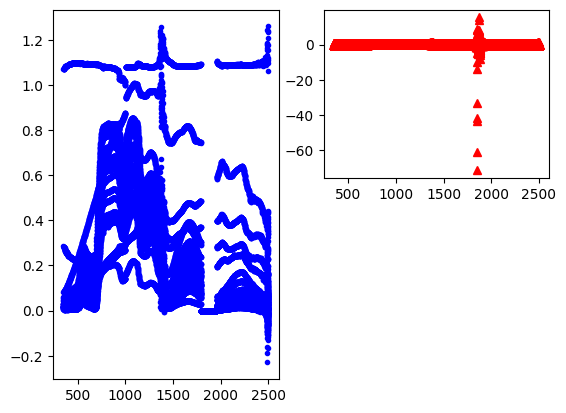

In [5]:
#filtering A spectril signature

import numpy
print(specsig[:,0])
specsig[:,0:1]
import matplotlib.pyplot as plt
#plt.plot(specsig[:,0],specsig[:,1])
specsig1 = numpy.zeros((2151,30))
specsig2 = numpy.zeros((2151,30))
leng=len(specsig)
#print(leng)
specsig1[:,0] = specsig[:,0]
for i in range(leng):
    for j in range(1,30,1):
        if(specsig[i,j] >=0 and specsig[i,j] <= 1.0):
            specsig1[i,j]=specsig[i,j]
        else:
            specsig1[i,j]= 0
#print(specsig1[:,0:1])       
specsig2[:,0] = specsig[:,0]
specsig2[0:991,1:30]=specsig[0:991,1:30]
specsig2[991:1096,1:30]=specsig[991:1096,1:30]
specsig2[1096:1441,1:30]= specsig[1096:1441,1:30]
specsig2[1441:1606,1:30]=0
specsig2[1606:2151,1:30]= specsig[1606:2151,1:30]
print(specsig2.shape)
plt.subplot(1, 2 , 1) # row 1, col 2 index 1
#plt.plot(specsig2[0:991,0],specsig2[0:991,2],'b.')
#plt.plot(specsig2[1096:1441,0],specsig2[1096:1441,2],'b.')
#plt.plot(specsig2[1606:2100,0],specsig2[1606:2100,2],'b.')
plt.plot(specsig2[:,0],specsig2[:,1:],'b.')
plt.subplot(2, 2, 2) 
plt.plot(specsig[:,0],specsig[:,1:],'r^')
plt.show

In [6]:
csv_dir = "/content/drive/MyDrive/"
file='allspectral_filtered.csv'
pd.DataFrame(specsig2).to_csv(csv_dir+file)

In [ ]:
import pandas as pd
# reading FWHM file for prisma
csv_dir = "/content/drive/MyDrive/"
file='Hyperion_FWHM.csv'
df = pd.read_csv(csv_dir+file,header =0)
print(df.shape)
fwhm= (df.iloc[:,:].values).astype('float32')

In [ ]:
import pandas as pd
# reading FWHM file for prisma
csv_dir = "/content/drive/MyDrive/"
file='U.csv'
df = pd.read_csv(csv_dir+file,header =0)
print(df.shape)
U= (df.iloc[:,:].values).astype('float32')

In [ ]:
#resmapling spectral signatures to Prisma VNIR using FWHM
#resampling Hyperion images
#specsig3 = np.zeros((63,31))
#specsig3[:,0]=fwhm[:,2]
#specsig3[:,1]=fwhm[:,3]
specsig3 = np.zeros((198,31))
specsig3[:,0]=fwhm[:,0]
specsig3[:,1]=fwhm[:,1]
for j in range(1,30):
   # n=0
    for i in range(0,198):
        f= round(fwhm[i,1])
        k= round(f+fwhm[i,2])
        s=0
        l=0
        for m in range (0,2151):
           
            if specsig2[m,0] >= f and specsig2[m,0]<=k:
                s= specsig2[m,j]+ s
                l=l+1
        av= s/l
        specsig3[i,j+1]= av
 

In [ ]:
csv_dir = "/content/drive/MyDrive/"
file='Hyperion_FWHM_resampled.csv'
pd.DataFrame(specsig3).to_csv(csv_dir+file)

In [ ]:
import pysptools.classification as cls
#image3 = np.transpose(image,(1,2,0))/10000.0
print( image3.shape, image3.max())
U2= U[:,0:198] #np.transpose(U[:,0:198],(1,0))
specsig4=specsig3[:,2:]
print(U2.shape, image3.shape, image3.max())
path = '/content/results'
#E-masked= U
c = cls.SID()
myim=c.classify(image3, U, threshold=0.00001)
#classification_analysis(image3, path, U)
#cls.SAM(image3, specsig4,0.1,None)

In [ ]:
 #c.plot_single_map(path, 1, constrained=False, suffix= None)
#plot(myim,'Spectral', None, path)
print(myim.max())

In [ ]:
print(fwhm[:,1])

In [ ]:
import psutil
split_bar = '='*20
memory_info = psutil.virtual_memory()._asdict()
print(f"{split_bar} Memory Usage {split_bar}")
for k,v in memory_info.items():
  print(k, v)
print(f"{split_bar} CPU Usage {split_bar}")
print(f"CPU percent: {psutil.cpu_percent()}%")